# Introduction

This notebook will focus primarily on modelling, various types of Univariate Models.

<b>Interesting Read : </b>[Forecasting Principles & Practices](https://otexts.com/fpp2/)

<img src='../Materials/fpp2.png' width='250' align='left'>

# Imports

In [1]:
# General
from warnings import filterwarnings
filterwarnings('ignore')
from cycler import cycler

# Data Wrangling
import pandas as pd
import numpy as np

# Data Viualization
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpl

# Time Series Specific
from statsmodels.tsa.seasonal import seasonal_decompose

# Datetime
from datetime import datetime

# Dataholder
from helperhandler import dataHolder

# Path and Variable Initialisation

In [2]:
root_path = '../'
raw_datapath = root_path+'Raw Data/'
prepared_datapath = root_path+'Prepared Data/'

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,7)
plt.style.use('ggplot')

# Splitting Data

There is a need to split the data such that we land with three buckets of the Data:-

- Train, CV & Test Splits
    - Training Data - Data that the Model Learns upon
    - Cross Validation Data - Data on which we determine our hyperparameters/parameters of the model on
    - Test Data - Data on which we measure our `Metrics` as to how the model is doing on a dataset which it has never seen before, neither in Training or in Cross Validation Phase.

<img src='../Materials/SimpleTrainTestSplit.png'>

****
- Rolling Splits

Usually time series models that are built, are statistical based and in some cases mahine learning or deep learning based, but either ways these models are not that heavy that re-reunning these models every month to generate forecasts will be Computationally expensive, or atleast that is and has been true for most of the cases.

<img src='../Materials/SimpleRollingForecast.png' align='left' width='460'>
<img src='../Materials/SimpleRollingForecastWithStepAhead.png' align='left' width='460'>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
Credit : https://otexts.com/fpp2/accuracy.html


In [6]:
def generat_randomtsdata(tstart = '1990-01-01', tend = '2020-01-01', plot=False):
    rows = (pd.to_datetime(tend)-pd.to_datetime(tstart)).days+1
    simData = pd.DataFrame(columns=['Trend',  'Cyclicity', 'Seasonality', 'Residual'],
                           index=pd.date_range(tstart, tend, freq='1D'))
    
    _days=np.arange(rows)

    # Trend Componet
    simData['Trend'] = 2*np.arange(rows)/rows
    # Cyclicity Componet
    simData['Cyclicity'] = 0.3*np.sin(3*_days/rows * 2 * np.pi)
    # Seasonality - For Additive
    simData['Seasonality'] = 0.3*np.sin(_days/365 * 2 * np.pi)
    # Seasonality - For Multiplicative
    simData['Seasonality'] = 0.3*(_days/rows)*np.sin(_days/365 * 2 * np.pi)
    # Residual
    simData['Residual'] = np.random.random(rows)/10
    # Time Series
    simData['ts'] = simData.sum(axis=1)
    
    if plot : get_decompose_plot(simData)
    
    return simData


In [7]:
simData = generat_randomtsdata()
simData.head()

,Trend,Cyclicity,Seasonality,Residual,ts
1990-01-01,0.000000,0.000000,0.000000e+00,0.073812,0.073812
1990-01-02,0.000183,0.000516,4.712545e-07,0.060131,0.060830
1990-01-03,0.000365,0.001032,1.884739e-06,0.000105,0.001504
1990-01-04,0.000548,0.001548,4.239615e-06,0.001113,0.003213
1990-01-05,0.000730,0.002064,7.534487e-06,0.026882,0.029684


<b>TCT Split</b>

In [8]:
# Ratios
training_ratio = 0.8 
cv_ratio = 0.1

In [9]:
training = int(training_ratio*simData.shape[0])
cv = int(cv_ratio*simData.shape[0])
test = simData.shape[0]-training-cv

training_data = simData.iloc[:training, :]
cv_data = simData.iloc[training:training+cv, :]
test_data = simData.iloc[-test:, :]

training_data.shape, cv_data.shape, test_data.shape

((8766, 5), (1095, 5), (1097, 5))

In [10]:
print('Training Data ranges from {0} to {1}'.format(training_data.index.min(),
                                                    training_data.index.max()))
print('Cross Validation Data ranges from {0} to {1}'.format(cv_data.index.min(),
                                                            cv_data.index.max()))
print('Testing Data ranges from {0} to {1}'.format(test_data.index.min(),
                                                   test_data.index.max()))

Training Data ranges from 1990-01-01 00:00:00 to 2013-12-31 00:00:00
Cross Validation Data ranges from 2014-01-01 00:00:00 to 2016-12-30 00:00:00
Testing Data ranges from 2016-12-31 00:00:00 to 2020-01-01 00:00:00


<b>Rolling Origin Framework</b>

In [11]:
# Parameters
test_start = '2014-01-01'
ahead = 1
dfreq = 'D'


In [12]:
train_cv_data = simData[simData.index<test_start]
test_data  = simData[simData.index>=test_start]

print('Training-CV Data ranges from {0} to {1}'.format(train_cv_data.index.min(),
                                                       train_cv_data.index.max()))
print('Testing Data ranges from {0} to {1}'.format(test_data.index.min(),
                                                   test_data.index.max()))

Training-CV Data ranges from 1990-01-01 00:00:00 to 2013-12-31 00:00:00
Testing Data ranges from 2014-01-01 00:00:00 to 2020-01-01 00:00:00


In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
def train_model(traincv_data, test_data, 
                cv_window, ahead_offest,
                target_col, feature_cols,
                metric_func, metric='MAPE',):
    
    traincv_data.sort_index(inplace=True)
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    feat_cols = feature_cols
    model = None

    # Prepare Dates
    tstart_date = traincv_data.index[0]
    for tend_date in train_cv_data.index[-cv_window:-ahead_offest.days]:
        point_date = tend_date+ahead_offest

#         #print('Training Start Date : ', tstart_date.strftime('%Y-%m-%d'))
#         #print('Training End Date : ', tend_date.strftime('%Y-%m-%d'))
#         #print('Point Forecast Date : ', point_date.strftime('%Y-%m-%d')+'\n\n')
        
        # Filter the data
        _train_data = train_cv_data.truncate(before=tstart_date, after=tend_date)
        _cv_data = train_cv_data.loc[point_date].to_frame().T
        # Get X & Y
        _train_dataX = _train_data[feat_cols]
        _train_dataY = _train_data[target_col]
        
        _cv_dataX = _cv_data[feat_cols]
        _cv_dataY = _cv_data[target_col]
        
        
        # Fit your model on the _train_data
        # -------------FILL--------------
        model = LinearRegression()
        # Test your model on the _cv_data
        # -------------FILL--------------
        model.fit(_train_dataX, _train_dataY)
        # Calculate the metric for _cv_data
        # forecast and fill cvDF
        # -------------FILL--------------
        _forecast = model.predict(_cv_dataX)[0]
        _actual = _cv_dataY.values[0]

        cvDF.loc[point_date, 'Actual'] = _actual
        cvDF.loc[point_date, 'Forecast'] = _forecast
        cvDF.loc[point_date,  metric] = metric_func(_actual, _forecast)

    # Forecast on the Test Data
    _test_dataX = test_data[feat_cols]
    _test_dataY = test_data[target_col]
    testDF['Actual'] = _test_dataY
    testDF['Forecast'] = model.predict(_test_dataX)
    testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    return cvDF, testDF


In [15]:
mape_func = lambda y,yhat: np.round(100*(abs(y-yhat)/y),2)


res = train_model(traincv_data = train_cv_data, test_data = test_data,
                  cv_window = 50, ahead_offest = pd.DateOffset(days=3),
                  feature_cols = ['Trend', 'Seasonality'], target_col = 'ts',
                  metric='MAPE(%)', metric_func=mape_func)

cv_metric_sheet, test_metric_sheet = res


In [16]:
temp = lambda x,y : print(x+y) 

In [17]:
temp(1,9)

10


In [18]:
cv_metric_sheet.head()

,Actual,Forecast,MAPE(%)
2013-11-15,1.66744,1.51606,9.08
2013-11-16,1.70132,1.51939,10.69
2013-11-17,1.70621,1.52278,10.75
2013-11-18,1.64467,1.52622,7.2
2013-11-19,1.71913,1.52972,11.02


In [19]:
test_metric_sheet.head()

,Actual,Forecast,MAPE(%)
2014-01-01,1.856708,1.703160,8.27
2014-01-02,1.844467,1.707332,7.43
2014-01-03,1.833144,1.711497,6.64
2014-01-04,1.863356,1.715653,7.93
2014-01-05,1.866109,1.719800,7.84


In [20]:
print('MAPE for Cross Validation : ', np.round(cv_metric_sheet.iloc[:,-1].mean(),3))
print('MAPE for Test Data        : ', np.round(test_metric_sheet.iloc[:,-1].mean(),3))

MAPE for Cross Validation :  8.799
MAPE for Test Data        :  11.87


# Residual Diagnostics

Residual in a Time Series Model is what is left over after the Forecast, i.e `residual=Actual-Forecast`

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
- The residuals have constant variance.
- The residuals are normally distributed.

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
def residual_diagnostic(metric_sheet):
    metric_sheet=metric_sheet.copy()
    metric_sheet['Residuals'] = metric_sheet.Actual-metric_sheet.Forecast
    
    grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.2)
    series_ax = plt.subplot(grid[0:1, :])
    series_ax.set_title('Residuals')
    metric_sheet['Residuals'].plot(ax=series_ax)

    dist_ax = plt.subplot(grid[1, 0])
    dist_ax.set_title('Residual Distribution')
    sns.distplot(metric_sheet['Residuals'], ax=dist_ax, rug=True, rug_kws={'color':'r'})

    acf_ax = plt.subplot(grid[1, 1])
    acf_ax.set_title('Auto-Correlation')
    _=plot_acf(metric_sheet['Residuals'], ax=acf_ax)
    


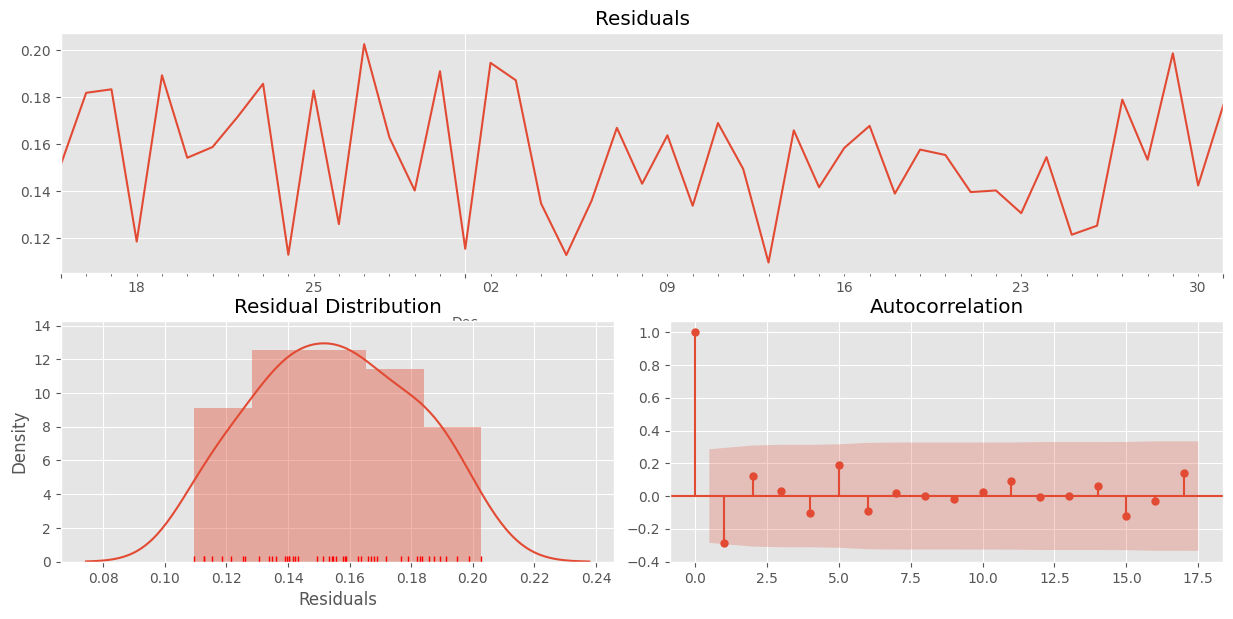

In [22]:
residual_diagnostic(cv_metric_sheet)

# Simple Univariate Models

- Average Model : Taking Average of the Available Data
- Näive Model : The Prior Value is your next Vaue
- Seasonal Näive Model : Give the Same Value as Prior Season, i.e Forecast for Jan-2020 will be the value of Jan-2019


<b>Average Model</b>

In [23]:
def train_model(traincv_data, test_data, 
                cv_window, ahead_offest,
                target_col,
                metric_func, metric='MAPE',):
    
    comb_data = pd.concat([traincv_data, test_data])
    traincv_data.sort_index(inplace=True)
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    # Prepare Dates
    tstart_date = traincv_data.index[0]
    for tend_date in traincv_data.index[-cv_window:-ahead_offest.days]:
        point_date = tend_date+ahead_offest
        
        # Filter the data
        _train_data = traincv_data.truncate(before=tstart_date, after=tend_date)
        _cv_data = traincv_data.loc[point_date].to_frame().T

        _train_dataY = _train_data[target_col]
        _cv_dataY = _cv_data[target_col]

        _forecast = _train_dataY.mean()
        _actual = _cv_dataY.values[0]

        cvDF.loc[point_date, 'Actual'] = _actual
        cvDF.loc[point_date, 'Forecast'] = _forecast
        cvDF.loc[point_date,  metric] = metric_func(_actual, _forecast)

    # Forecast on the Test Data
    _test_dataY = test_data[target_col]
    testDF['Actual'] = _test_dataY
    testDF['Forecast'] = comb_data.expanding().mean()
    testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    return cvDF, testDF



In [24]:
mape_func=lambda y,yhat: np.round(100*(abs(y-yhat)/y),2)


res = train_model(traincv_data = train_cv_data, test_data = test_data,
                  cv_window = 1000, ahead_offest = pd.DateOffset(days=3),
                  target_col = 'ts',
                  metric='MAPE(%)', metric_func=mape_func)

avg_cvmsheet, avg_tmsheet = res
print('MAPE for Cross Validation : ', np.round(avg_cvmsheet.iloc[:,-1].mean(),3))
print('MAPE for Test Data        : ', np.round(avg_tmsheet.iloc[:,-1].mean(),3))

MAPE for Cross Validation :  53.826
MAPE for Test Data        :  46.314


<b>Näive Model</b>

In [25]:
def train_model(traincv_data, test_data, 
                cv_window, ahead_offest,
                target_col,
                metric_func, metric='MAPE'):
    
    comb_data = pd.concat([traincv_data, test_data])
    traincv_data.sort_index(inplace=True)
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    # Prepare Dates
    tstart_date = traincv_data.index[0]
    for tend_date in traincv_data.index[-cv_window:-ahead_offest.days]:
        point_date = tend_date+ahead_offest
        
        # Filter the data
        _train_data = traincv_data.truncate(before=tstart_date, after=tend_date)
        _cv_data = traincv_data.loc[point_date].to_frame().T
        
        _train_dataY = _train_data[target_col]
        _cv_dataY = _cv_data[target_col]

        _forecast = _train_dataY[-1]
        _actual = _cv_dataY.values[0]

        cvDF.loc[point_date, 'Actual'] = _actual
        cvDF.loc[point_date, 'Forecast'] = _forecast
        cvDF.loc[point_date,  metric] = metric_func(_actual, _forecast)

    # Forecast on the Test Data
    _prev_dt = test_data.index-ahead_offest
    _test_dataY = test_data[target_col]
    testDF['Actual'] = _test_dataY
    testDF['Forecast'] = comb_data.truncate(_prev_dt.min(), _prev_dt.max())[target_col].values
    testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    return cvDF, testDF


In [26]:
mape_func=lambda y,yhat: np.round(100*(abs(y-yhat)/y),2)

res = train_model(traincv_data = train_cv_data, test_data = test_data,
                  cv_window = 1000, ahead_offest = pd.DateOffset(days=3),
                  target_col = 'ts',
                  metric='MAPE(%)', metric_func=mape_func)

naive_cvmsheet, naive_tmsheet = res
print('MAPE for Cross Validation : ', np.round(naive_cvmsheet.iloc[:,-1].mean(),3))
print('MAPE for Test Data        : ', np.round(naive_tmsheet.iloc[:,-1].mean(),3))


MAPE for Cross Validation :  1.864
MAPE for Test Data        :  2.013


<b>Seasonal Näive Model</b>

In [27]:
def train_model(traincv_data, test_data, 
                cv_window, ahead_offest,
                target_col,
                metric_func, metric='MAPE',):
    
    comb_data = pd.concat([traincv_data, test_data])
    traincv_data.sort_index(inplace=True)
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    # Prepare Dates
    tstart_date = traincv_data.index[0]
    for tend_date in traincv_data.index[-cv_window:-ahead_offest.days]:
        point_date = tend_date+ahead_offest

        # Filter the data
        _train_data = traincv_data.loc[point_date-pd.DateOffset(months=12)]
        
        _cv_data = traincv_data.loc[point_date].to_frame().T
        
        _cv_dataY = _cv_data[target_col]

        _forecast = _train_data[target_col]
        _actual = _cv_dataY.values[0]

        cvDF.loc[point_date, 'Actual'] = _actual
        cvDF.loc[point_date, 'Forecast'] = _forecast
        cvDF.loc[point_date,  metric] = metric_func(_actual, _forecast)

    #Forecast on the Test Data
    _prev_seasondt = test_data.index-pd.DateOffset(months=12)
    
    _test_dataY = test_data[target_col]
    testDF['Actual'] = _test_dataY
    testDF['Forecast'] = comb_data.truncate(_prev_seasondt.min(), _prev_seasondt.max())[target_col].values
    testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    return cvDF, testDF


In [28]:
mape_func=lambda y,yhat: np.round(100*(abs(y-yhat)/y),2)

res = train_model(traincv_data = train_cv_data, test_data = test_data,
                  cv_window = 1000, ahead_offest = pd.DateOffset(days=3),
                  target_col = 'ts',
                  metric='MAPE(%)', metric_func=mape_func)

snaive_cvmsheet, snaive_tmsheet = res
print('MAPE for Cross Validation : ', np.round(snaive_cvmsheet.iloc[:,-1].mean(),3))
print('MAPE for Test Data        : ', np.round(snaive_tmsheet.iloc[:,-1].mean(),3))


MAPE for Cross Validation :  6.477
MAPE for Test Data        :  6.388


In [29]:
combined_msheet = simData[['ts']].copy()
combined_msheet.columns = ['Actual']

combined_msheet['Average CV'] = avg_cvmsheet.Forecast
combined_msheet['Average Test'] = avg_tmsheet.Forecast
combined_msheet['Average UL'] = avg_tmsheet.Forecast+1.96*avg_tmsheet.Forecast.expanding().var()
combined_msheet['Average LL'] = avg_tmsheet.Forecast-1.96*avg_tmsheet.Forecast.expanding().var()

combined_msheet['Naive CV'] = naive_cvmsheet.Forecast
combined_msheet['Naive Test'] = naive_tmsheet.Forecast
combined_msheet['Naive UL'] = naive_tmsheet.Forecast+1.96*naive_tmsheet.Forecast.expanding().var()
combined_msheet['Naive LL'] = naive_tmsheet.Forecast-1.96*naive_tmsheet.Forecast.expanding().var()

combined_msheet['Seasonal Naive CV'] = snaive_cvmsheet.Forecast
combined_msheet['Seasonal Naive Test'] = snaive_tmsheet.Forecast
combined_msheet['Seasonal Naive UL'] = snaive_tmsheet.Forecast+1.96*snaive_tmsheet.Forecast.expanding().var()
combined_msheet['Seasonal Naive LL'] = snaive_tmsheet.Forecast-1.96*snaive_tmsheet.Forecast.expanding().var()
combined_msheet.head()

# combined_msheet = combined_msheet.iloc[-4000:,:]


,Actual,Average CV,Average Test,Average UL,Average LL,Naive CV,Naive Test,Naive UL,Naive LL,Seasonal Naive CV,Seasonal Naive Test,Seasonal Naive UL,Seasonal Naive LL
1990-01-01,0.073812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-02,0.060830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.001504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.003213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.029684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


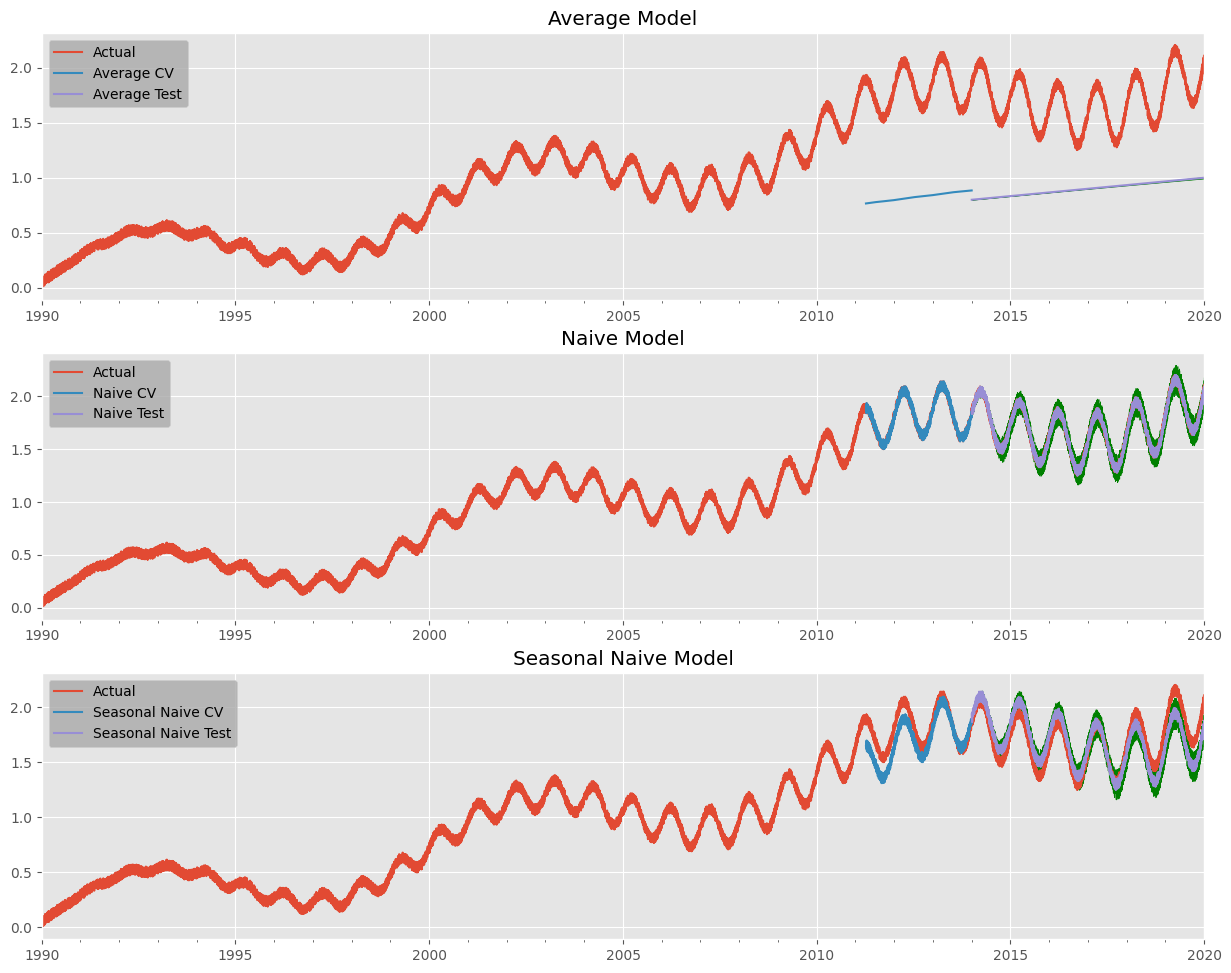

In [30]:
fig, axes = plt.subplots(3,1, figsize=(15,12))

# Plot the Actual Series
combined_msheet[['Actual', 'Average CV', 'Average Test']].plot(ax=axes[0],
                                                           title='Average Model')
axes[0].fill_between(combined_msheet['Average UL'].dropna().index,
                     combined_msheet['Average UL'].dropna(),
                     combined_msheet['Average LL'].dropna(), color='g')
# Plot for Naive Model
combined_msheet[['Actual', 'Naive CV', 'Naive Test']].plot(ax=axes[1],
                                                           title='Naive Model')
axes[1].fill_between(combined_msheet['Naive UL'].dropna().index,
                     combined_msheet['Naive UL'].dropna(),
                     combined_msheet['Naive LL'].dropna(), color='g')
# Plot for Seasonal Naive Model
combined_msheet[['Actual', 'Seasonal Naive CV', 'Seasonal Naive Test']].plot(ax=axes[2],
                                                                             title='Seasonal Naive Model')
axes[2].fill_between(combined_msheet['Seasonal Naive UL'].dropna().index,
                     combined_msheet['Seasonal Naive UL'].dropna(),
                     combined_msheet['Seasonal Naive LL'].dropna(), color='g')

# AR Model

**Auto Regressive Model** - Model Explaining a process where the current Time Series $Y_{t}$ can be described as a process being governed by its own lags $Y_{t-i}$ $\Rightarrow$  Predict the time series based on the values that variable assumed in the past..

A process being governed as an $AR(p)$ Model can be written as :-

\begin{equation}
    AR(p)\Rightarrow Y_{t} = \beta_{0} + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + .... + \beta_{p}Y_{t-p} + \varepsilon_{t}
\end{equation}

\begin{equation}
    \hat Y_{t} = \beta_{0} + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + .... + \beta_{p}Y_{t-p}
\end{equation}

For ex : 
\begin{equation}
    AR(1)\Rightarrow Y_{t} = \beta_{0} + \beta_{1}Y_{t-1} + \varepsilon_{t}
\end{equation}

\begin{equation}
    \hat Y_{t} = \beta_{0} + \beta_{1}Y_{t-1}
\end{equation}

Where : 
- $Y_{t}$ equation modelling the data generation process
- $\hat Y_{t}$ equation modelling the forecast, you will notice that the $\varepsilon_{t}$ is missing from this equation, thats because in that month we dont have access to that error yet.

Basically, the interpretation of the above model processes will go like this $\Rightarrow$ 

My current month value $Y_{t}$ can be `described` or `regressed` by $Y_{t-1}$, $Y_{t-2}$ ... $Y_{t-p}$, and the error term $\varepsilon_{t}$ that reflects how `off` our prediction of the current month might be..


For AR Model:

- `PACF` plot can hint us as to which lags are significant for us to consider regressing upon
- `ACF` plot will show a gradual decay in the plot with the increasing lags being engulfed by the error bands

<b>Generating the Data for $AR(1)$</b>

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [34]:
def ar1_datagen(beta0=1, beta1= -0.8, size=10_00):
    gendata = [beta0]
    errors = np.random.normal(size=size)
    for i in range(1, size):
        y_t = beta0 + beta1*gendata[i-1] + errors[i]
        gendata.append(y_t)
    return np.array(gendata)


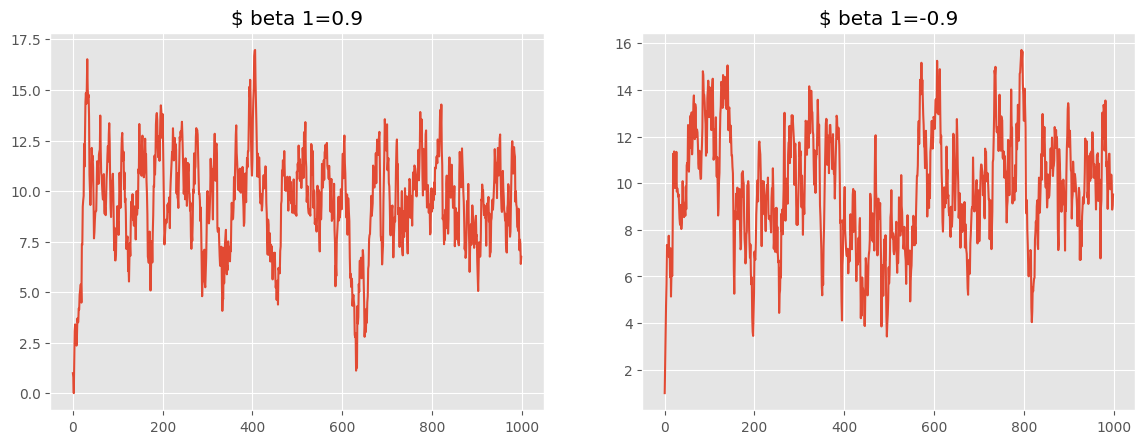

In [35]:
_beta1 = 0.9
_beta2 = -0.9

ar1_bp = ar1_datagen(beta1=_beta1)
ar1_bn = ar1_datagen(beta1=-_beta2)

fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].plot(ar1_bp)
axes[0].set_title(f'$ beta {1}={_beta1}')
axes[1].plot(ar1_bn)
_=axes[1].set_title(f'$ beta {1}={_beta2}')


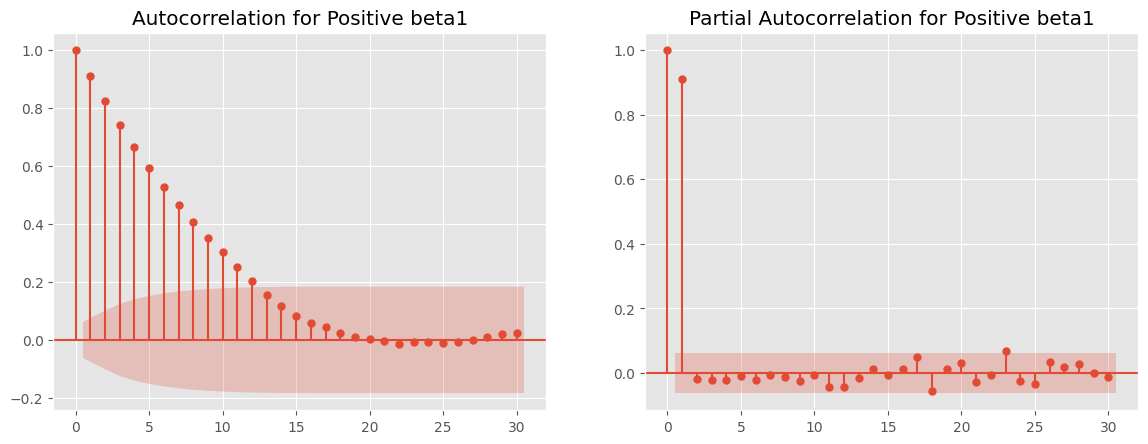

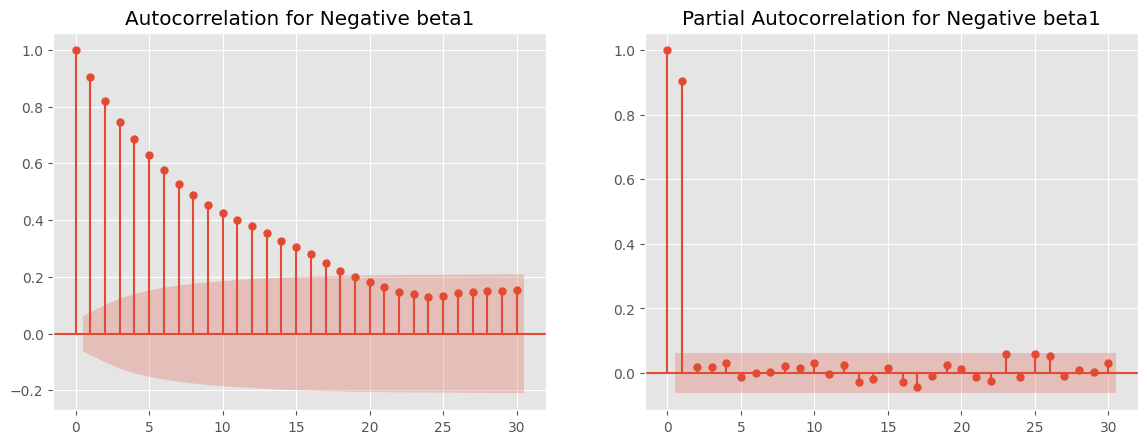

In [36]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
_=plot_acf(ar1_bp, ax=axes[0], title='Autocorrelation for Positive beta1')
_=plot_pacf(ar1_bp, ax=axes[1], title='Partial Autocorrelation for Positive beta1')
fig, axes = plt.subplots(1,2, figsize=(14,5))
_=plot_acf(ar1_bn, ax=axes[0], title='Autocorrelation for Negative beta1')
_=plot_pacf(ar1_bn, ax=axes[1], title='Partial Autocorrelation for Negative beta1')

# MA Model

*NOTE : DO NOT CONFUSE THE TERM MOVING AVERAGE WITH THE `MOVING AVERAGE` FROM THE SMOOTHING OPERATIONS, you can interpret it more like moving around the averages*

**Moving Average Model** - Model Explaining a process where the current Time Series $Y_{t}$ can be described as a process being governed by its previous forecasting $\varepsilon_{t-i}$ errors and the $\mu$

A process being governed as an $MA(q)$ Model can be written as :-

\begin{equation}
    MA(q)\Rightarrow Y_{t} = \mu + \phi_{1}\varepsilon_{t-1} + \phi_{2}\varepsilon_{t-2} + .... + \phi_{q}\varepsilon_{t-q} + \varepsilon_{t}
\end{equation}

\begin{equation}
    \hat Y_{t} = \mu + \phi_{1}\varepsilon_{t-1} + \phi_{2}\varepsilon_{t-2} + .... + \phi_{q}\varepsilon_{t-p}
\end{equation}

For ex : 
\begin{equation}
    MA(1)\Rightarrow Y_{t} = \mu + \phi_{1}\varepsilon_{t-1} + \varepsilon_{t}
\end{equation}

\begin{equation}
    \hat Y_{t} = \mu + \phi_{1}\varepsilon_{t-1}
\end{equation}

Where : 
- $Y_{t}$ equation modelling the data generation process
- $\hat Y_{t}$ equation modelling the forecast, you will notice that the $\varepsilon_{t}$ is missing from this equation, thats because in that month we dont have access to that error yet.

Basically, the interpretation of the above model processes will go like this $\Rightarrow$ 

My current month value $Y_{t}$ can be `described` or `regressed` by $\varepsilon_{t-1}$, $\varepsilon_{t-2}$ ... $\varepsilon_{t-p}$, and the error term $\varepsilon_{t}$ that reflects how `off` our prediction of the current month might be..


For MA Model:

- `ACF` plot can hint us as to which lags are significant
- `ACF` plot will show an abrupt shut down in the values, which might be right after the $q$ lag

[Should i use MA or AR?](https://stats.stackexchange.com/a/107855)

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [41]:
def ma1_datagen(mu=20, phi1= -0.8, size=1_00):
    gendata = [mu]
    errors = np.random.randn(size)
    for i in range(1, size):
        y_t = mu+phi1*errors[i-1] + errors[i]
        gendata.append(y_t)
    return np.array(gendata)


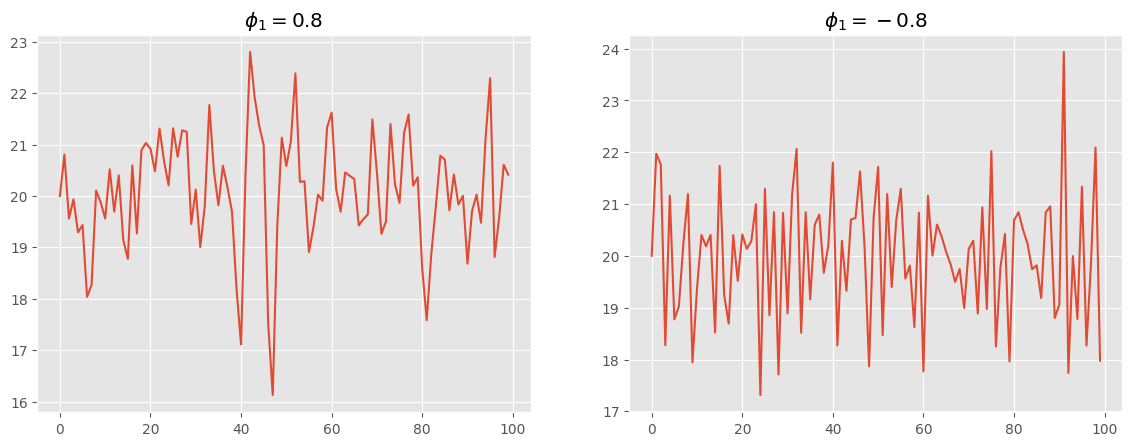

In [42]:
ma1_p_8 = ma1_datagen(phi1=0.5)
ma1_n_8 = ma1_datagen(phi1=-0.5)

fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].plot(ma1_p_8)
axes[0].set_title(r'$ \phi_{1}=0.8$')
axes[1].plot(ma1_n_8)
_=axes[1].set_title(r'$ \phi_{1}=-0.8$')


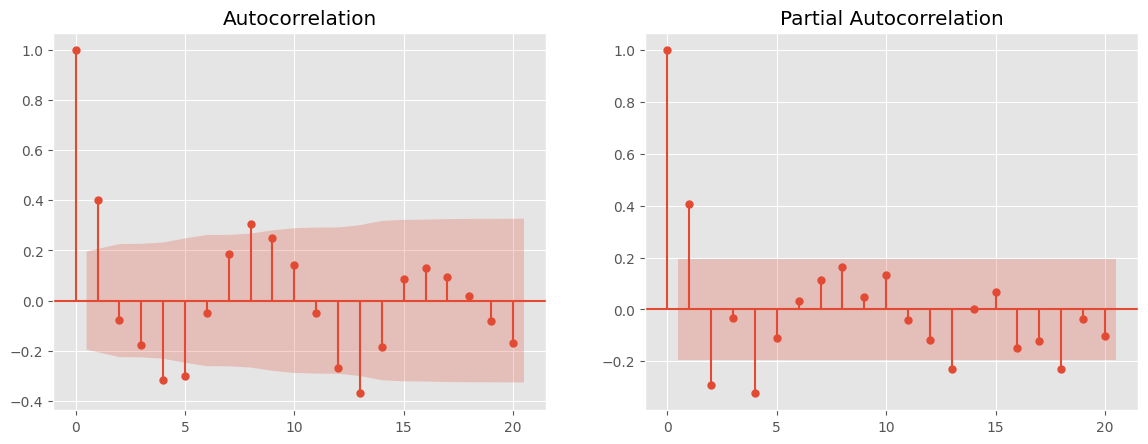

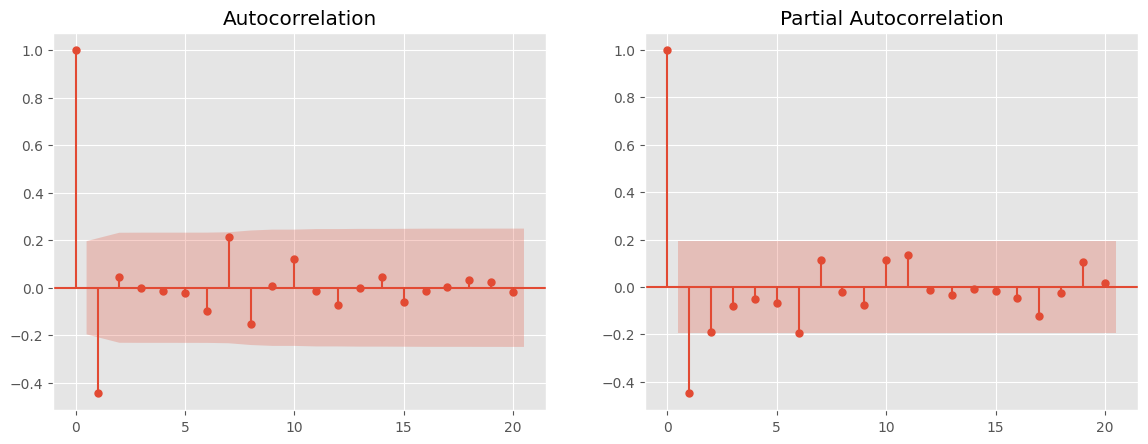

In [43]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
_=plot_acf(ma1_p_8, ax=axes[0])
_=plot_pacf(ma1_p_8, ax=axes[1])
fig, axes = plt.subplots(1,2, figsize=(14,5))
_=plot_acf(ma1_n_8, ax=axes[0])
_=plot_pacf(ma1_n_8, ax=axes[1])

# ARIMA Model

**AutoRegressive Integrated Moving Average Model** - Model Explaining a process where the current Time Series $Y_{t}$ can be described as a process being governed by its $MA(q)$ and $AR(p)$ terms, alongside a $d$ parameter which belongs to the differencing of the series.

**ARIMA** model is usually advisable when the time series is non stationary and is having a trend, not seasonality.

A process being governed as an $ARIMA(p,d,q)$ Model can be written as :-

\begin{equation}
    ARIMA(p,d,q)\Rightarrow Z_{t} = \mu + \phi_{1}\varepsilon_{t-1} + \phi_{2}\varepsilon_{t-2} + .... + \phi_{1}\varepsilon_{t-q} + \beta_{0} + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + .... + \beta_{1}Y_{t-p} + \varepsilon_{t}
\end{equation}

\begin{equation}
    \hat Z_{t} = \mu + \phi_{1}\varepsilon_{t-1} + \phi_{2}\varepsilon_{t-2} + .... + \phi_{1}\varepsilon_{t-q} + \beta_{0} + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + .... + \beta_{1}Y_{t-p}
\end{equation}

For ex : 
\begin{equation}
    ARIMA(1,1,1)\Rightarrow Z_{t} = \mu + \beta_{0} + \phi_{1}\varepsilon_{t-1} + \beta_{1}Y_{t-1} + \varepsilon_{t}
\end{equation}

\begin{equation}
    \hat Z_{t} = \mu + \beta_{0} + \phi_{1}\varepsilon_{t-1} + \beta_{1}Y_{t-1}
\end{equation}

Where : 
- $Y_{t}$ equation modelling the data generation process
- $Z_{t}$ is the differenced $Y_{t}$ series
- $\hat Y_{t}$ equation modelling the forecast, you will notice that the $\varepsilon_{t}$ is missing from this equation, thats because in that month we dont have access to that error yet.

Basically, the interpretation of the above model processes will go like this $\Rightarrow$ 

My current month value $Y_{t}$ can be `described` or `regressed` by $\varepsilon_{t-1}$, $\varepsilon_{t-2}$ ... $\varepsilon_{t-p}$, and the error term $\varepsilon_{t}$ that reflects how `off` our prediction of the current month might be..


For MA Model:

- `ACF` plot can hint us as to which lags are significant
- `ACF` plot will show an abrupt shut down in the values, which might be right after the $q$ lag

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [45]:
def arima111_datagen(mu=20, phi1= -0.8, beta0=1, beta1=0.8, size=1_00):
    gendata = [mu+beta0]
    errors = np.random.randn(size)
    for i in range(1, size):
        y_t = mu+beta0+phi1*errors[i-1] + beta1*gendata[i-1] + errors[i]
        gendata.append(y_t)
    return np.array(gendata)

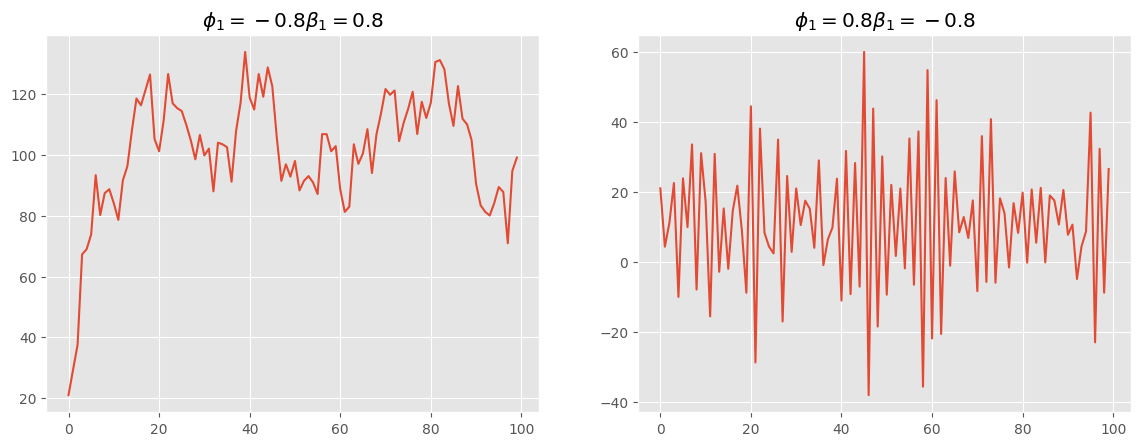

In [46]:
arima111_1 = arima111_datagen(phi1= 10, beta1=0.8)
arima111_2 = arima111_datagen(phi1= -10, beta1=-0.8)

fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].plot(arima111_1)
axes[0].set_title(r'$ \phi_{1}=-0.8 \beta_{1}=0.8$')
axes[1].plot(arima111_2)
_=axes[1].set_title(r'$ \phi_{1}=0.8 \beta_{1}=-0.8$')

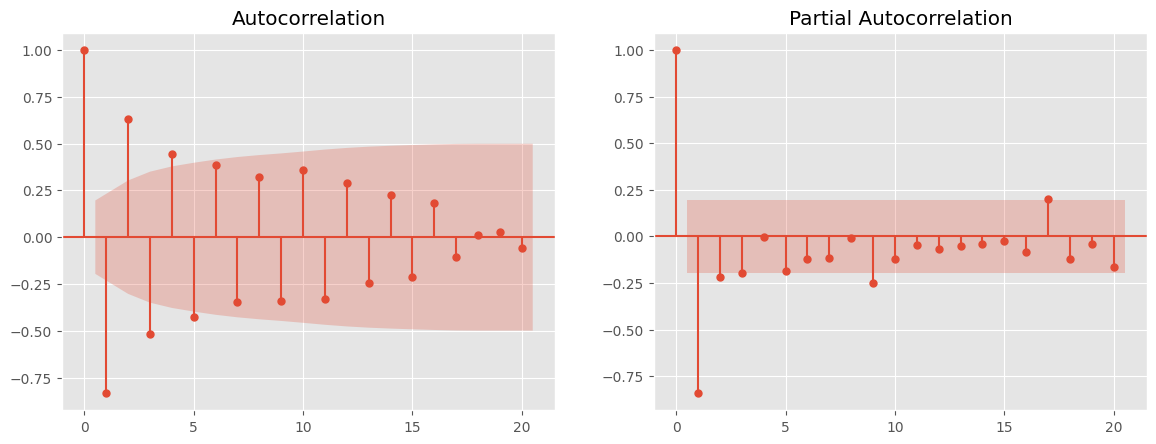

In [47]:

fig, axes = plt.subplots(1,2, figsize=(14,5))
_=plot_acf(arima111_2, ax=axes[0])
_=plot_pacf(arima111_2, ax=axes[1])


# SARIMA Model

**Seaonal AutoRegressive Integrated Moving Average Model** - In addition to ARIMA model, this class of model takes into account the **Seasonality** in the dataset. Finally the SARIMA model is defined by the following parameters :

- p : Auto-Regressive order of the Series
- d : Integrated(Differencing) order of the Series
- q : Moving Average order of the Series

- P : Auto-Regressive order of the Seasonality
- D : Integrated(Differencing order of the Seasonality
- Q : Moving Average order of the Seasonality

- m : Number of time steps for the period to occur

**SARIMA** model is usually advisable when the time series is non stationary and is having a trend and a seasonality

# Model Comparision

- Akaike Information Criterion (AIC)

\begin{equation}
    AIC = 2k - 2ln(\hat L)
\end{equation}

- Bayesian information criterion (BIC)

\begin{equation}
    BIC = k.ln(n) - 2ln(\hat L)
\end{equation}

- [DIC](https://www.youtube.com/watch?v=xS4jDHQfP2o)
- [WAIC](https://www.youtube.com/watch?v=xS4jDHQfP2o)

Where :- 

- $k$ - Number of Parameters in the model

- $n$ - Total Number of DataPoints

- $\hat L$ - Maximum value of the Likelihood function of the linear model

In [48]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [49]:
dataHolder.load_data()

In [50]:
mdata = dataHolder.bucket['usa_cpi'].data.copy()
mdata.index.freq = pd.infer_freq(mdata.index)

mdata.head()

,CPI
Date,
2007-10-01,209.190
2007-11-01,210.834
2007-12-01,211.445
2008-01-01,212.174
2008-02-01,212.687


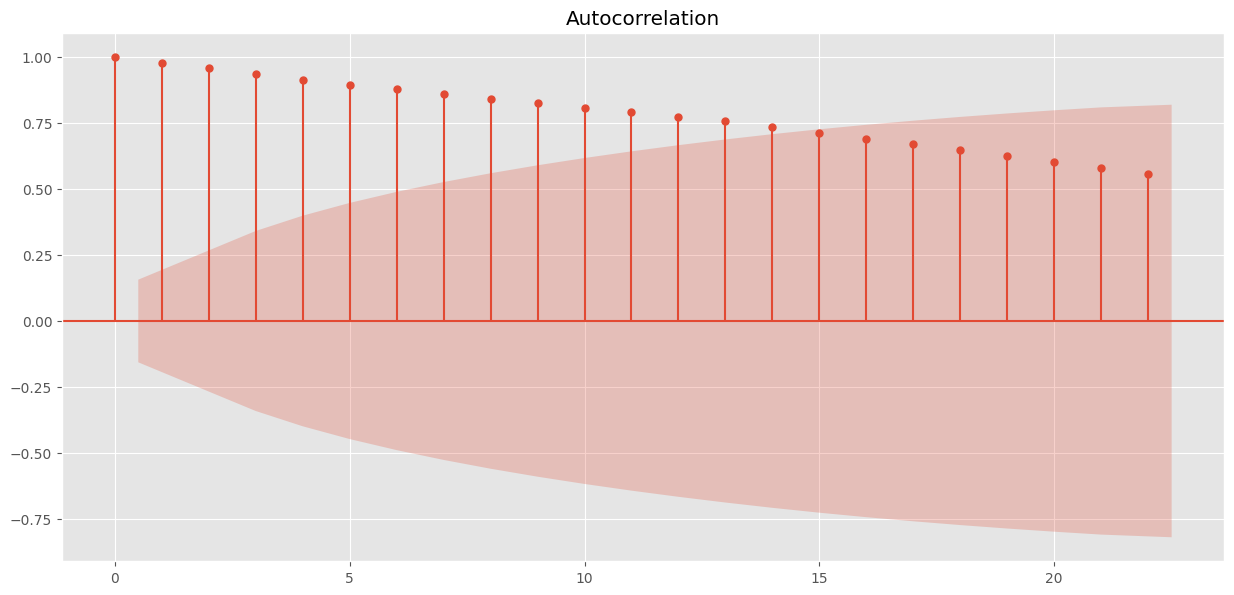

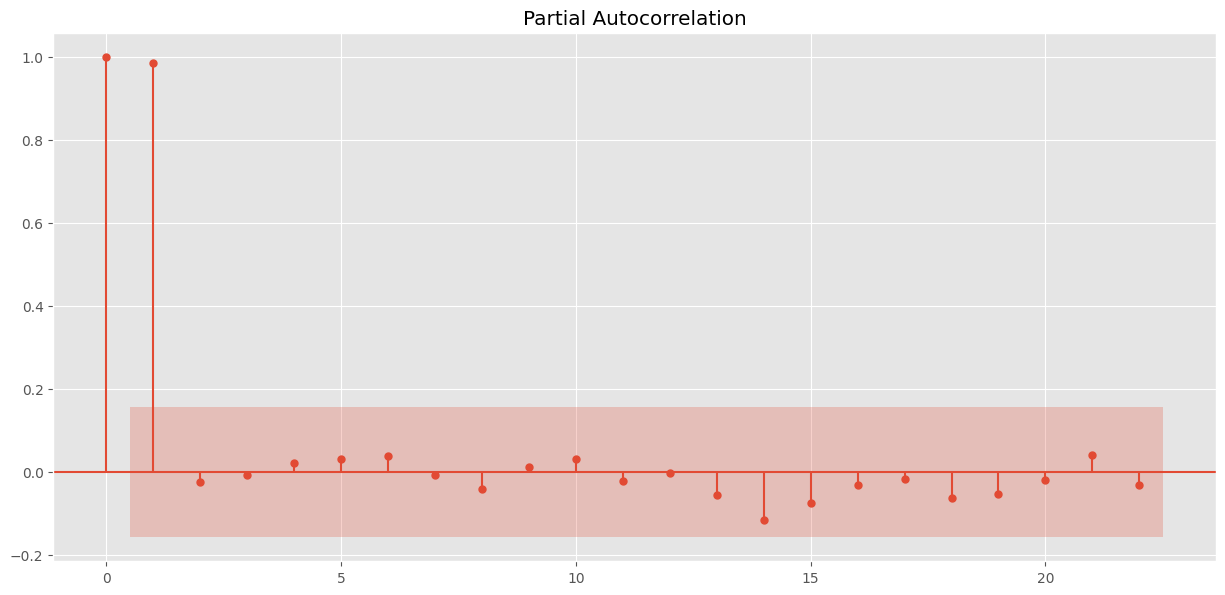

In [51]:
_=plot_acf(mdata)
_=plot_pacf(mdata)

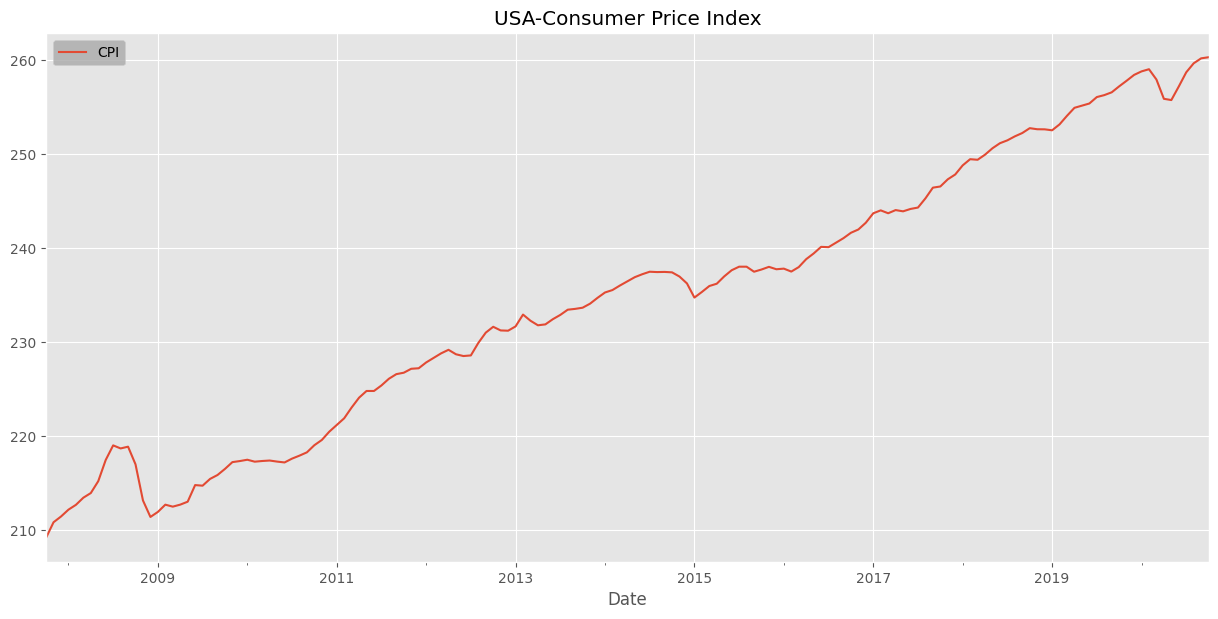

In [52]:
dataHolder.bucket['usa_cpi'].exploratory_plot()

In [55]:
model1 = ARIMA(mdata.CPI, order=(1,1,1))
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.CPI   No. Observations:                  156
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -135.654
Method:                       css-mle   S.D. of innovations              0.577
Date:                Mon, 07 Dec 2020   AIC                            279.307
Time:                        13:49:32   BIC                            291.507
Sample:                    11-01-2007   HQIC                           284.262
                         - 10-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3335      0.086      3.873      0.000       0.165       0.502
ar.L1.D.CPI     0.2928      0.121      2.418      0.016       0.055       0.530
ma.L1.D.CPI     0.3244      0.112      2.898      0.004       0.105       0.544
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.4152           +0.0000j            3.4152            0.0000
MA.1           -3.0827           +0.0000j            3.0827            0.5000
-----------------------------------------------------------------------------
"""

In [56]:
model1 = ARIMA(mdata.CPI, order=(4,2,2))
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D2.CPI   No. Observations:                  155
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -135.855
Method:                       css-mle   S.D. of innovations              0.573
Date:                Mon, 07 Dec 2020   AIC                            287.710
Time:                        13:49:50   BIC                            312.057
Sample:                    12-01-2007   HQIC                           297.599
                         - 10-01-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0001      0.002     -0.079      0.937      -0.003       0.003
ar.L1.D2.CPI     0.1371      0.755      0.182      0.856      -1.343       1.617
ar.L2.D2.CPI     0.1069      0.476      0.225      0.822      -0.826       1.040
ar.L3.D2.CPI    -0.1654      0.170     -0.975      0.330      -0.498       0.167
ar.L4.D2.CPI     0.0129      0.094      0.138      0.890      -0.171       0.197
ma.L1.D2.CPI    -0.5047      0.751     -0.672      0.501      -1.976       0.967
ma.L2.D2.CPI    -0.4952      0.751     -0.660      0.509      -1.966       0.976
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7016           -0.0000j            1.7016           -0.5000
AR.2            1.2075           -1.5180j            1.9397           -0.1431
AR.3            1.2075           +1.5180j            1.9397            0.1431
AR.4           12.0703           -0.0000j           12.0703           -0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -2.0192           +0.0000j            2.0192            0.5000
-----------------------------------------------------------------------------
"""

# Random Testing Space